In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

In [2]:
df=pd.read_csv('dataset/24-hours Delhi Power Consumption dataset.csv')

In [3]:
df['timestamp']=pd.to_datetime(df['timestamp'])

In [4]:
def assign_compensation_method(row):
    if row['is_holiday'] == 1:
        return 'Lower Power Supply'
    elif row['solar_generation'] > 200:
        return 'Increased Renewable Energy Integration'
    elif row['hour_of_day'] >= 18 and row['hour_of_day'] <= 22:
        return 'Peak Load Shifting'
    elif row['temperature'] > 35:
        return 'Increased Power Supply'
    else:
        return 'Normal Operation'

df['compensation_method'] = df.apply(assign_compensation_method, axis=1)

print(df[['timestamp', 'load', 'compensation_method']].head(10))


            timestamp   load                     compensation_method
0 2023-01-01 00:00:00  18493                        Normal Operation
1 2023-01-01 01:00:00  17090                        Normal Operation
2 2023-01-01 02:00:00  16052                        Normal Operation
3 2023-01-01 03:00:00  15356                        Normal Operation
4 2023-01-01 04:00:00  14936                        Normal Operation
5 2023-01-01 05:00:00  14884                        Normal Operation
6 2023-01-01 06:00:00  15314  Increased Renewable Energy Integration
7 2023-01-01 07:00:00  16591  Increased Renewable Energy Integration
8 2023-01-01 08:00:00  18271                        Normal Operation
9 2023-01-01 09:00:00  19470  Increased Renewable Energy Integration


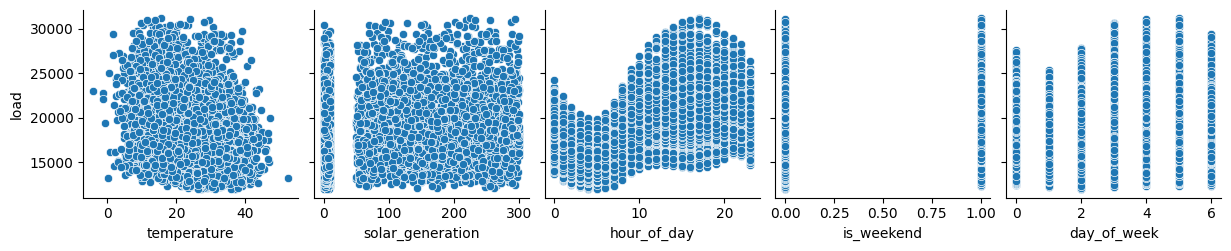

In [5]:
# Plot pairplot between load and other features
sns.pairplot(df, x_vars=['temperature', 'solar_generation', 'hour_of_day', 'is_weekend','day_of_week'], y_vars='load', diag_kind='kde')
plt.show()

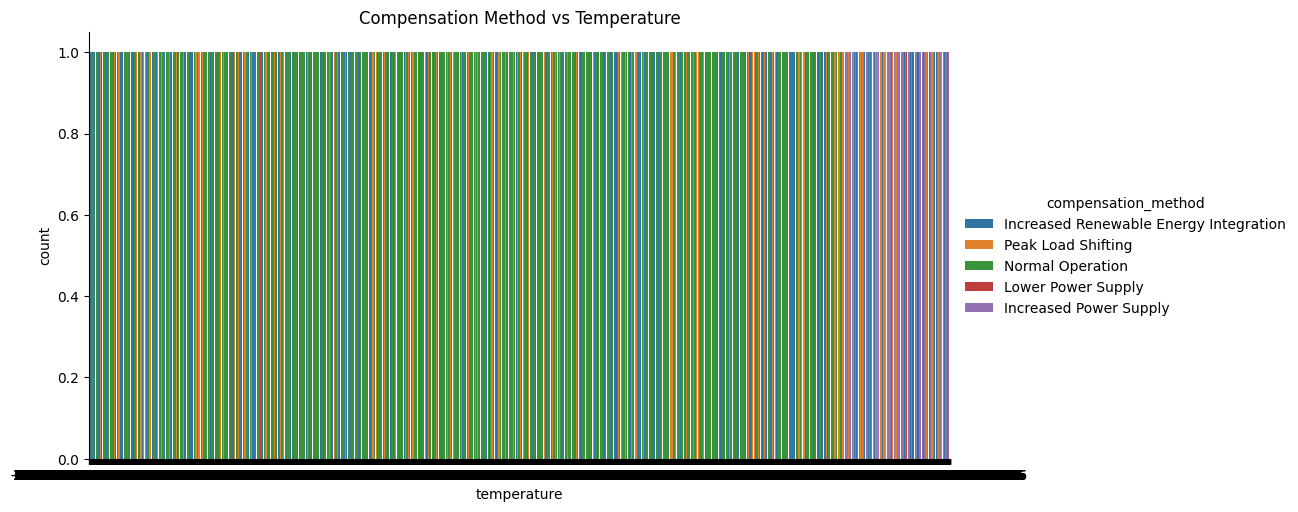

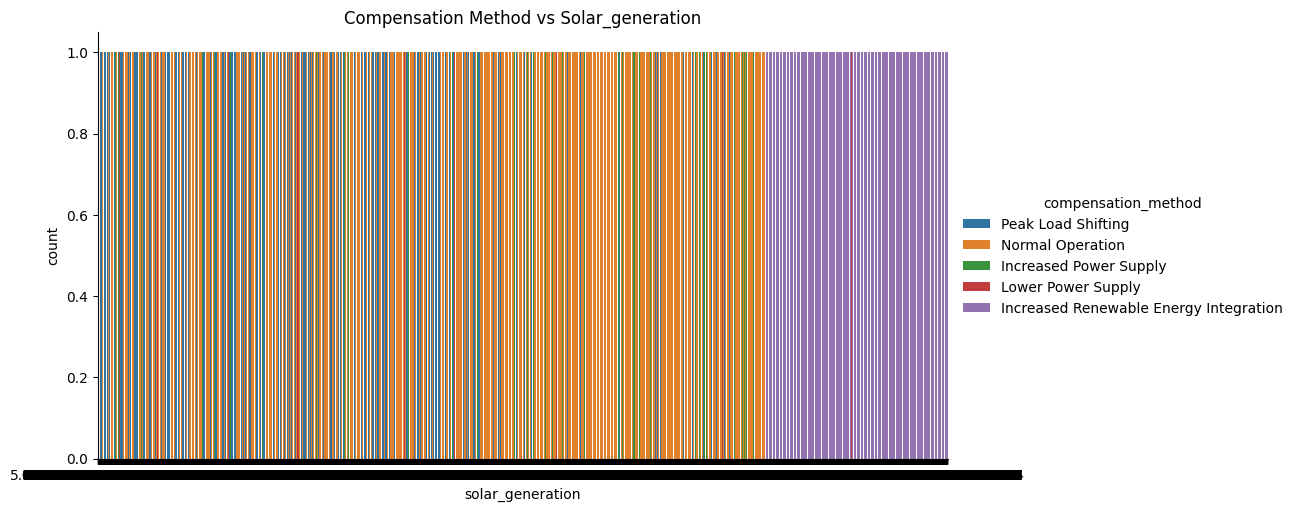

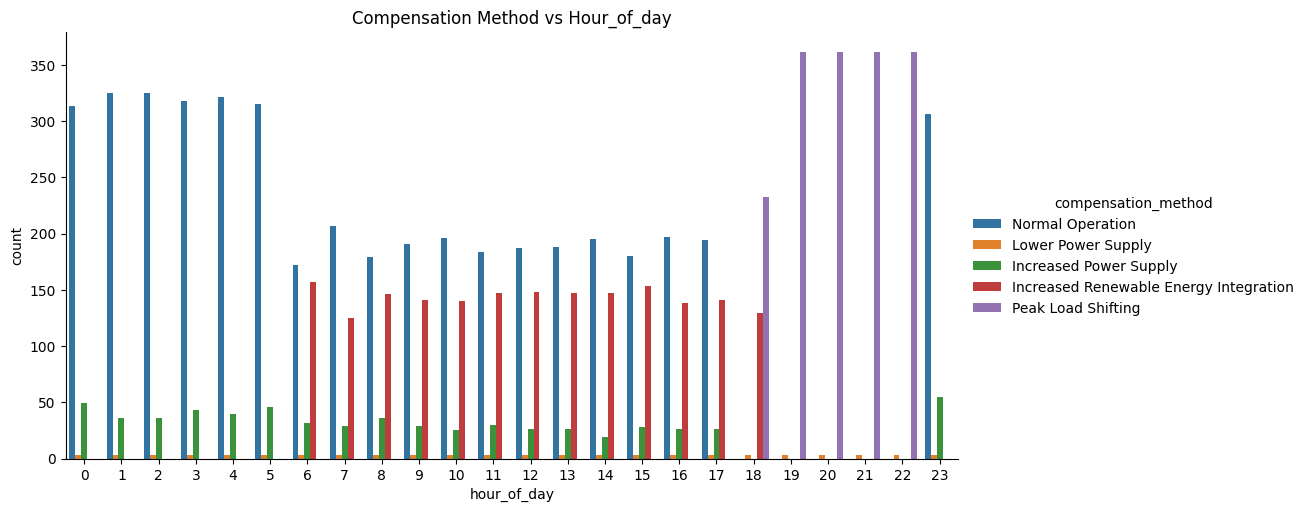

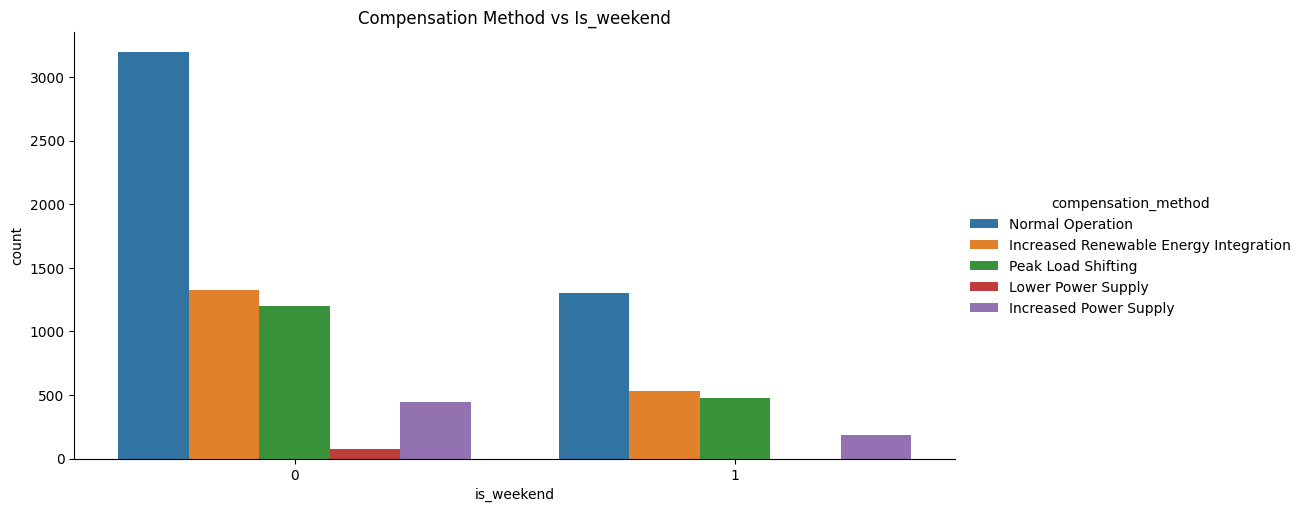

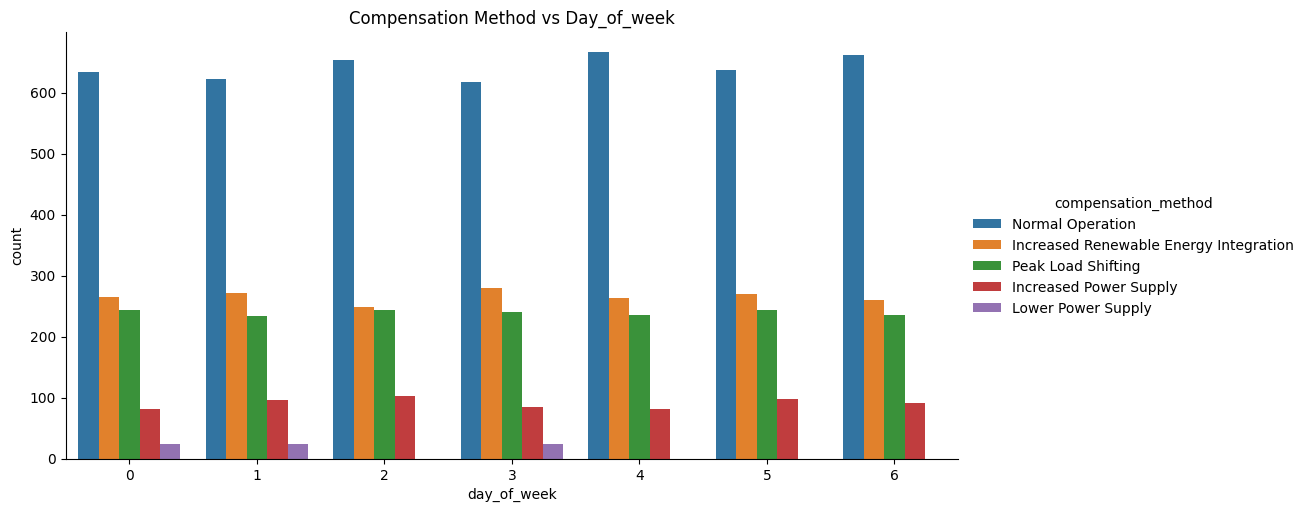

In [6]:
# Plot graphs between compensation_method and other features
features = ['temperature', 'solar_generation', 'hour_of_day', 'is_weekend', 'day_of_week']

for feature in features:
    sns.catplot(x=feature, hue='compensation_method', data=df, kind='count', height=5, aspect=2)
    plt.title(f'Compensation Method vs {feature.capitalize()}')
    plt.show()

In [7]:
df.head()

,Unnamed: 0,timestamp,day_of_week,hour_of_day,is_weekend,temperature,is_holiday,solar_generation,load,compensation_method
0,0,2023-01-01 00:00:00,6,0,1,17.483571,0,7.819507,18493,Normal Operation
1,1,2023-01-01 01:00:00,6,1,1,14.308678,0,0.886376,17090,Normal Operation
2,2,2023-01-01 02:00:00,6,2,1,18.238443,0,0.798470,16052,Normal Operation
3,3,2023-01-01 03:00:00,6,3,1,22.615149,0,3.067700,15356,Normal Operation
4,4,2023-01-01 04:00:00,6,4,1,13.829233,0,0.359479,14936,Normal Operation


In [8]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [9]:
X = df[['temperature', 'solar_generation', 'hour_of_day', 'load', 'is_holiday']]
y=df['compensation_method']
X_reg = df[['temperature', 'solar_generation', 'hour_of_day', 'is_holiday']]
y_reg = df['load']
le = LabelEncoder()
y = le.fit_transform(y)

In [10]:
X_train, X_test, y_train, y_test=train_test_split(X, y, test_size=0.3, random_state=42)
X_reg_train, X_reg_test, y_reg_train, y_reg_test = train_test_split(X_reg, y_reg, test_size=0.3, random_state=42)

In [11]:
from sklearn.preprocessing import StandardScaler

from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Conv1D, MaxPooling1D, Flatten
from keras.optimizers import Adam
from keras.layers import BatchNormalization
from keras.layers import Activation
#ann

# Normalize the data
scaler_reg = StandardScaler()
scaler_cls = StandardScaler()

X_reg_train_scaled = scaler_reg.fit_transform(X_reg_train)
X_reg_test_scaled = scaler_reg.transform(X_reg_test)
X_train_scaled = scaler_cls.fit_transform(X_train)
X_test_scaled = scaler_cls.transform(X_test)



In [12]:
from sklearn.tree import DecisionTreeClassifier
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

dt = DecisionTreeClassifier()
dt.fit(X_train_scaled, y_train)

#extensive network of FFNN for regression
# Reshape the data for LSTM
X_reg_train_lstm = X_reg_train_scaled.reshape((X_reg_train_scaled.shape[0], 1, X_reg_train_scaled.shape[1]))
X_reg_test_lstm = X_reg_test_scaled.reshape((X_reg_test_scaled.shape[0], 1, X_reg_test_scaled.shape[1]))
X_train_lstm = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_test_lstm = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)

# LSTM for regression
lstm_reg = Sequential()
lstm_reg.add(LSTM(50, activation='relu', input_shape=(1, X_reg_train_scaled.shape[1]), return_sequences=True))
lstm_reg.add(LSTM(50, activation='relu'))
lstm_reg.add(Dense(50, activation='relu'))
lstm_reg.add(Dense(1))
lstm_reg.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

lstm_reg.fit(X_reg_train_lstm, y_reg_train, epochs=100, batch_size=32, validation_data=(X_reg_test_lstm, y_reg_test), callbacks=[early_stopping, reduce_lr])


Epoch 1/100
192/192 [==============================] - 6s 13ms/step - loss: 331116736.0000 - mae: 17888.4941 - val_loss: 307342304.0000 - val_mae: 17211.3164 - lr: 0.0010
Epoch 2/100
192/192 [==============================] - 2s 10ms/step - loss: 143827152.0000 - mae: 10630.3975 - val_loss: 23025300.0000 - val_mae: 3758.8875 - lr: 0.0010
Epoch 3/100
192/192 [==============================] - 2s 11ms/step - loss: 18716734.0000 - mae: 3353.9387 - val_loss: 17651106.0000 - val_mae: 3258.1060 - lr: 0.0010
Epoch 4/100
192/192 [==============================] - 2s 10ms/step - loss: 15737187.0000 - mae: 3074.1377 - val_loss: 15063990.0000 - val_mae: 3010.6863 - lr: 0.0010
Epoch 5/100
192/192 [==============================] - 2s 10ms/step - loss: 13305177.0000 - mae: 2824.4490 - val_loss: 12756651.0000 - val_mae: 2765.5405 - lr: 0.0010
Epoch 6/100
192/192 [==============================] - 2s 10ms/step - loss: 11223952.0000 - mae: 2584.4353 - val_loss: 10868372.0000 - val_mae: 2538.9158 - lr:

In [13]:
# using GRU for regression

from keras.layers import GRU

# GRU for regression
gru_reg = Sequential()
gru_reg.add(GRU(50, activation='relu', input_shape=(1, X_reg_train_scaled.shape[1]), return_sequences=True))
gru_reg.add(GRU(50, activation='relu'))
gru_reg.add(Dense(50, activation='relu'))
gru_reg.add(Dense(1))
gru_reg.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

gru_reg.fit(X_reg_train_lstm, y_reg_train, epochs=100, batch_size=32, validation_data=(X_reg_test_lstm, y_reg_test), callbacks=[early_stopping, reduce_lr])

Epoch 1/100
192/192 [==============================] - 6s 17ms/step - loss: 325314496.0000 - mae: 17724.5000 - val_loss: 276373216.0000 - val_mae: 16300.8203 - lr: 0.0010
Epoch 2/100
192/192 [==============================] - 3s 14ms/step - loss: 92607504.0000 - mae: 7786.2324 - val_loss: 9344006.0000 - val_mae: 2319.5386 - lr: 0.0010
Epoch 3/100
192/192 [==============================] - 3s 14ms/step - loss: 8024176.0000 - mae: 2158.5444 - val_loss: 8348965.0000 - val_mae: 2200.7520 - lr: 0.0010
Epoch 4/100
192/192 [==============================] - 2s 12ms/step - loss: 7415108.5000 - mae: 2076.3396 - val_loss: 7819875.0000 - val_mae: 2130.1440 - lr: 0.0010
Epoch 5/100
192/192 [==============================] - 2s 11ms/step - loss: 7029468.0000 - mae: 2021.6296 - val_loss: 7485921.0000 - val_mae: 2093.8845 - lr: 0.0010
Epoch 6/100
192/192 [==============================] - 2s 12ms/step - loss: 6773276.0000 - mae: 1988.4381 - val_loss: 7251049.5000 - val_mae: 2041.2717 - lr: 0.0010
Epo

In [14]:
# using Bidirectional LSTM for regression

from keras.layers import GRU
from keras.layers import Bidirectional, LSTM

# Bidirectional LSTM for regression
# Bidirectional LSTM for regression
bilstm_reg = Sequential()
bilstm_reg.add(Bidirectional(LSTM(50, activation='relu', return_sequences=True), input_shape=(1, X_reg_train_scaled.shape[1])))
bilstm_reg.add(Bidirectional(LSTM(50, activation='relu')))
bilstm_reg.add(Dense(50, activation='relu'))
bilstm_reg.add(Dense(1))
bilstm_reg.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

bilstm_reg.fit(X_reg_train_lstm, y_reg_train, epochs=100, batch_size=32, validation_data=(X_reg_test_lstm, y_reg_test), callbacks=[early_stopping, reduce_lr])

Epoch 1/100
192/192 [==============================] - 7s 19ms/step - loss: 315519584.0000 - mae: 17422.3281 - val_loss: 213832048.0000 - val_mae: 14215.7158 - lr: 0.0010
Epoch 2/100
192/192 [==============================] - 3s 16ms/step - loss: 55530780.0000 - mae: 5805.8408 - val_loss: 20240138.0000 - val_mae: 3485.2834 - lr: 0.0010
Epoch 3/100
192/192 [==============================] - 3s 15ms/step - loss: 17270658.0000 - mae: 3222.5212 - val_loss: 15816338.0000 - val_mae: 3084.8066 - lr: 0.0010
Epoch 4/100
192/192 [==============================] - 3s 15ms/step - loss: 13368140.0000 - mae: 2825.3999 - val_loss: 12349851.0000 - val_mae: 2716.4702 - lr: 0.0010
Epoch 5/100
192/192 [==============================] - 3s 16ms/step - loss: 10492872.0000 - mae: 2489.6792 - val_loss: 9977851.0000 - val_mae: 2416.7554 - lr: 0.0010
Epoch 6/100
192/192 [==============================] - 3s 16ms/step - loss: 8631279.0000 - mae: 2248.6467 - val_loss: 8518731.0000 - val_mae: 2221.6174 - lr: 0.00

In [15]:
# using multistep CNN-stacked-LSTM

from keras.layers import RepeatVector
from keras.regularizers import l2


# Revised model with adjustments
cnn_lstm_reg = Sequential()
cnn_lstm_reg.add(Conv1D(filters=64, kernel_size=1, activation='relu', input_shape=(X_reg_train_lstm.shape[1], X_reg_train_lstm.shape[2])))
cnn_lstm_reg.add(MaxPooling1D(pool_size=1))
cnn_lstm_reg.add(BatchNormalization())
cnn_lstm_reg.add(Dropout(0.2))
cnn_lstm_reg.add(LSTM(100, activation='relu', return_sequences=True))
cnn_lstm_reg.add(Dropout(0.2))
cnn_lstm_reg.add(LSTM(50, activation='relu'))
cnn_lstm_reg.add(Dropout(0.2))
cnn_lstm_reg.add(Dense(25, activation='relu', kernel_regularizer=l2(0.001)))
cnn_lstm_reg.add(Dense(1))
optimizer = Adam(learning_rate=0.0001)
cnn_lstm_reg.compile(optimizer=optimizer, loss='mean_squared_error')

cnn_lstm_reg.fit(
    X_reg_train_lstm, y_reg_train,
    epochs=100,
    batch_size=64,
    validation_data=(X_reg_test_lstm, y_reg_test),
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/100
96/96 [==============================] - 8s 21ms/step - loss: 335647968.0000 - val_loss: 340289728.0000 - lr: 1.0000e-04
Epoch 2/100
96/96 [==============================] - 1s 13ms/step - loss: 335628928.0000 - val_loss: 340274240.0000 - lr: 1.0000e-04
Epoch 3/100
96/96 [==============================] - 1s 12ms/step - loss: 335348544.0000 - val_loss: 339939392.0000 - lr: 1.0000e-04
Epoch 4/100
96/96 [==============================] - 1s 13ms/step - loss: 333764576.0000 - val_loss: 337661952.0000 - lr: 1.0000e-04
Epoch 5/100
96/96 [==============================] - 1s 13ms/step - loss: 329183712.0000 - val_loss: 331131488.0000 - lr: 1.0000e-04
Epoch 6/100
96/96 [==============================] - 1s 13ms/step - loss: 319825696.0000 - val_loss: 318320448.0000 - lr: 1.0000e-04
Epoch 7/100
96/96 [==============================] - 1s 13ms/step - loss: 303547328.0000 - val_loss: 297554848.0000 - lr: 1.0000e-04
Epoch 8/100
96/96 [==============================] - 1s 14ms/step - l

In [16]:
# using ensemble learning(BiLSTM+GRU) with XGBoost

from xgboost import XGBRegressor

# Ensemble learning
from keras.models import Model
from keras.layers import concatenate, Input

# Define the GRU model
input_layer_gru = Input(shape=(1, X_reg_train_scaled.shape[1]))
gru_layer = GRU(50, activation="relu", return_sequences=True)(input_layer_gru)
gru_layer = GRU(50, activation="relu")(gru_layer)
gru_out = Dense(50, activation="relu")(gru_layer)
gru_model = Model(inputs=input_layer_gru, outputs=gru_out)

# Define the BiLSTM model
input_layer_bilstm = Input(shape=(1, X_reg_train_scaled.shape[1]))
bilstm_layer = Bidirectional(LSTM(50, activation="relu", return_sequences=True))(input_layer_bilstm)
bilstm_layer = Bidirectional(LSTM(50, activation="relu"))(bilstm_layer)
bilstm_out = Dense(50, activation="relu")(bilstm_layer)
bilstm_model = Model(inputs=input_layer_bilstm, outputs=bilstm_out)

# Concatenate the outputs of the GRU and BiLSTM models
combined = concatenate([gru_model.output, bilstm_model.output])

# Add a final dense layer
final_output = Dense(1)(combined)

# Define the final model
ensemble_model = Model(inputs=[gru_model.input, bilstm_model.input], outputs=final_output)

# Compile the model
ensemble_model.compile(optimizer="adam", loss="mean_squared_error", metrics=["mae"])

# Fit the model
ensemble_model.fit(
    [X_reg_train_lstm, X_reg_train_lstm],
    y_reg_train,
    epochs=100,
    batch_size=32,
    validation_data=([X_reg_test_lstm, X_reg_test_lstm], y_reg_test),
    callbacks=[early_stopping, reduce_lr],
)

# Define the XGBoost model
xgb = XGBRegressor(objective="reg:squarederror", n_estimators=1000, learning_rate=0.01)

# Fit the model
xgb.fit(ensemble_model.predict([X_reg_train_lstm, X_reg_train_lstm]), y_reg_train)


Epoch 1/100
192/192 [==============================] - 11s 28ms/step - loss: 312458272.0000 - mae: 17323.2480 - val_loss: 196897472.0000 - val_mae: 13606.6602 - lr: 0.0010
Epoch 2/100
192/192 [==============================] - 4s 23ms/step - loss: 42690072.0000 - mae: 4935.9043 - val_loss: 13253698.0000 - val_mae: 2824.4333 - lr: 0.0010
Epoch 3/100
192/192 [==============================] - 4s 23ms/step - loss: 11331985.0000 - mae: 2596.0076 - val_loss: 10652157.0000 - val_mae: 2507.4265 - lr: 0.0010
Epoch 4/100
192/192 [==============================] - 5s 23ms/step - loss: 9189879.0000 - mae: 2322.3796 - val_loss: 8948877.0000 - val_mae: 2293.2063 - lr: 0.0010
Epoch 5/100
192/192 [==============================] - 4s 23ms/step - loss: 7913454.0000 - mae: 2150.9546 - val_loss: 8016155.0000 - val_mae: 2158.7285 - lr: 0.0010
Epoch 6/100
192/192 [==============================] - 5s 23ms/step - loss: 7197849.0000 - mae: 2045.6757 - val_loss: 7515675.0000 - val_mae: 2087.4792 - lr: 0.0010

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [17]:
#GRU performance

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error,root_mean_squared_error

# Make predictions on the test set for regression (peak supply)
y_reg_pred_gnb = gru_reg.predict(X_reg_test_lstm)
reg_mse_gnb = mean_squared_error(y_reg_test, y_reg_pred_gnb)
reg_mae_gnb = mean_absolute_error(y_reg_test, y_reg_pred_gnb)
reg_r2_gnb = r2_score(y_reg_test, y_reg_pred_gnb)
reg_rmse_gnb = root_mean_squared_error(y_reg_test, y_reg_pred_gnb)
reg_mape_gnb = mean_absolute_percentage_error(y_reg_test, y_reg_pred_gnb)

y_mean=np.mean(y_reg_test)
CV_RMSE=(reg_rmse_gnb/y_mean) * 100

print(f"Regression Model Mean Squared Error: {reg_mse_gnb:.2f}")
print(f"Regression Model Mean Absolute Error: {reg_mae_gnb:.2f}")
print(f"Regression Model R^2 Score: {reg_r2_gnb:.2f}")
print(f"Regression Model Root Mean Squared Error: {reg_rmse_gnb:.2f}")
print(f"Regression Model Mean Absolute Percentage Error: {reg_mape_gnb * 100:.2f}%")
print(f"Regression Model Coefficient of Variation of Root Mean Squared Error: {CV_RMSE:.2f}%")


82/82 [==============================] - 0s 2ms/step
Regression Model Mean Squared Error: 5335704.45
Regression Model Mean Absolute Error: 1697.74
Regression Model R^2 Score: 0.56
Regression Model Root Mean Squared Error: 2309.91
Regression Model Mean Absolute Percentage Error: 9.08%
Regression Model Coefficient of Variation of Root Mean Squared Error: 12.75%


In [18]:
# Bi-LSTM performance

y_reg_pred_gnb = bilstm_reg.predict(X_reg_test_lstm)
reg_mse_gnb = mean_squared_error(y_reg_test, y_reg_pred_gnb)
reg_mae_gnb = mean_absolute_error(y_reg_test, y_reg_pred_gnb)
reg_r2_gnb = r2_score(y_reg_test, y_reg_pred_gnb)
reg_rmse_gnb = root_mean_squared_error(y_reg_test, y_reg_pred_gnb)
reg_mape_gnb = mean_absolute_percentage_error(y_reg_test, y_reg_pred_gnb)

y_mean=np.mean(y_reg_test)
CV_RMSE=(reg_rmse_gnb/y_mean) * 100

print(f"Regression Model Mean Squared Error: {reg_mse_gnb:.2f}")
print(f"Regression Model Mean Absolute Error: {reg_mae_gnb:.2f}")
print(f"Regression Model R^2 Score: {reg_r2_gnb:.2f}")
print(f"Regression Model Root Mean Squared Error: {reg_rmse_gnb:.2f}")
print(f"Regression Model Mean Absolute Percentage Error: {reg_mape_gnb * 100:.2f}%")
print(f"Regression Model Coefficient of Variation of Root Mean Squared Error: {CV_RMSE:.2f}%")

82/82 [==============================] - 1s 3ms/step
Regression Model Mean Squared Error: 5290326.63
Regression Model Mean Absolute Error: 1703.62
Regression Model R^2 Score: 0.56
Regression Model Root Mean Squared Error: 2300.07
Regression Model Mean Absolute Percentage Error: 9.15%
Regression Model Coefficient of Variation of Root Mean Squared Error: 12.70%


In [19]:
#CNN-Stacked-LSTM performance

y_reg_pred_gnb = cnn_lstm_reg.predict(X_reg_test_lstm)
reg_mse_gnb = mean_squared_error(y_reg_test, y_reg_pred_gnb)
reg_mae_gnb = mean_absolute_error(y_reg_test, y_reg_pred_gnb)
reg_r2_gnb = r2_score(y_reg_test, y_reg_pred_gnb)
reg_rmse_gnb = root_mean_squared_error(y_reg_test, y_reg_pred_gnb)
reg_mape_gnb = mean_absolute_percentage_error(y_reg_test, y_reg_pred_gnb)

y_mean=np.mean(y_reg_test)
CV_RMSE=(reg_rmse_gnb/y_mean) * 100

print(f"Regression Model Mean Squared Error: {reg_mse_gnb:.2f}")
print(f"Regression Model Mean Absolute Error: {reg_mae_gnb:.2f}")
print(f"Regression Model R^2 Score: {reg_r2_gnb:.2f}")
print(f"Regression Model Root Mean Squared Error: {reg_rmse_gnb:.2f}")
print(f"Regression Model Mean Absolute Percentage Error: {reg_mape_gnb * 100:.2f}%")
print(f"Regression Model Coefficient of Variation of Root Mean Squared Error: {CV_RMSE:.2f}%")

82/82 [==============================] - 1s 4ms/step
Regression Model Mean Squared Error: 5823355.35
Regression Model Mean Absolute Error: 1776.34
Regression Model R^2 Score: 0.52
Regression Model Root Mean Squared Error: 2413.16
Regression Model Mean Absolute Percentage Error: 9.46%
Regression Model Coefficient of Variation of Root Mean Squared Error: 13.32%


In [20]:
#ensemble learning(BiLSTM+GRU) with XGBoost performance

y_reg_pred_gnb = xgb.predict(ensemble_model.predict([X_reg_test_lstm, X_reg_test_lstm]))
reg_mse_gnb = mean_squared_error(y_reg_test, y_reg_pred_gnb)
reg_mae_gnb = mean_absolute_error(y_reg_test, y_reg_pred_gnb)
reg_r2_gnb = r2_score(y_reg_test, y_reg_pred_gnb)
reg_rmse_gnb = root_mean_squared_error(y_reg_test, y_reg_pred_gnb)
reg_mape_gnb = mean_absolute_percentage_error(y_reg_test, y_reg_pred_gnb)

y_mean=np.mean(y_reg_test)
CV_RMSE=(reg_rmse_gnb/y_mean) * 100

print(f"Regression Model Mean Squared Error: {reg_mse_gnb:.2f}")
print(f"Regression Model Mean Absolute Error: {reg_mae_gnb:.2f}")
print(f"Regression Model R^2 Score: {reg_r2_gnb:.2f}")
print(f"Regression Model Root Mean Squared Error: {reg_rmse_gnb:.2f}")
print(f"Regression Model Mean Absolute Percentage Error: {reg_mape_gnb * 100:.2f}%")
print(f"Regression Model Coefficient of Variation of Root Mean Squared Error: {CV_RMSE:.2f}%")


82/82 [==============================] - 0s 5ms/step
Regression Model Mean Squared Error: 5357542.70
Regression Model Mean Absolute Error: 1705.13
Regression Model R^2 Score: 0.56
Regression Model Root Mean Squared Error: 2314.64
Regression Model Mean Absolute Percentage Error: 9.17%
Regression Model Coefficient of Variation of Root Mean Squared Error: 12.78%


In [21]:
#evaluation
from sklearn.metrics import mean_squared_error, accuracy_score, classification_report, confusion_matrix, mean_absolute_error, r2_score, root_mean_squared_error,mean_absolute_percentage_error

y_pred_dt = dt.predict(X_test_scaled)
class_accuracy_dt = accuracy_score(y_test, y_pred_dt)
print(f"Classification Model Accuracy: {class_accuracy_dt:.2f}")
print(classification_report(y_test, y_pred_dt, target_names=le.classes_))

# Make predictions on the test set for regression (peak supply)
y_reg_pred_gnb = lstm_reg.predict(X_reg_test_lstm)
reg_mse_gnb = mean_squared_error(y_reg_test, y_reg_pred_gnb)
reg_mae_gnb = mean_absolute_error(y_reg_test, y_reg_pred_gnb)
reg_r2_gnb = r2_score(y_reg_test, y_reg_pred_gnb)
reg_rmse_gnb = root_mean_squared_error(y_reg_test, y_reg_pred_gnb)
reg_mape_gnb = mean_absolute_percentage_error(y_reg_test, y_reg_pred_gnb)

y_mean=np.mean(y_reg_test)
CV_RMSE=(reg_rmse_gnb/y_mean) * 100

print(f"Regression Model Mean Squared Error: {reg_mse_gnb:.2f}")
print(f"Regression Model Mean Absolute Error: {reg_mae_gnb:.2f}")
print(f"Regression Model R^2 Score: {reg_r2_gnb:.2f}")
print(f"Regression Model Root Mean Squared Error: {reg_rmse_gnb:.2f}")
print(f"Regression Model Mean Absolute Percentage Error: {reg_mape_gnb * 100:.2f}%")
print(f"Regression Model Coefficient of Variation of Root Mean Squared Error: {CV_RMSE:.2f}%")
print(confusion_matrix(y_test, y_pred_dt))

Classification Model Accuracy: 1.00
                                        precision    recall  f1-score   support

                Increased Power Supply       1.00      1.00      1.00       183
Increased Renewable Energy Integration       1.00      1.00      1.00       559
                    Lower Power Supply       1.00      1.00      1.00        22
                      Normal Operation       1.00      1.00      1.00      1373
                    Peak Load Shifting       1.00      1.00      1.00       485

                              accuracy                           1.00      2622
                             macro avg       1.00      1.00      1.00      2622
                          weighted avg       1.00      1.00      1.00      2622

82/82 [==============================] - 0s 2ms/step
Regression Model Mean Squared Error: 5429505.16
Regression Model Mean Absolute Error: 1749.76
Regression Model R^2 Score: 0.55
Regression Model Root Mean Squared Error: 2330.13
Regression 

In [22]:
5288414>5842110

False

In [23]:
def predict_for_date(date, temperature, solar_generation, hour_of_day, is_holiday, dt, lstm_reg, le, scaler_cls, scaler_reg):
    new_data_class = pd.DataFrame({
        'temperature': [temperature],
        'solar_generation': [solar_generation],
        'hour_of_day': [hour_of_day],
        'load': [0],
        'is_holiday': [is_holiday]
    })

    new_data_reg = pd.DataFrame({
        'temperature': [temperature],
        'solar_generation': [solar_generation],
        'hour_of_day': [hour_of_day],
        'is_holiday': [is_holiday]
    })
    
    # Scale the data
    new_data_class_scaled = scaler_cls.transform(new_data_class)
    new_data_reg_scaled = scaler_reg.transform(new_data_reg)
    
    # Reshape for LSTM
    new_data_reg_lstm = new_data_reg_scaled.reshape((new_data_reg_scaled.shape[0], 1, new_data_reg_scaled.shape[1]))
    
    # Decision Tree predictions
    dt_class_pred = dt.predict(new_data_class_scaled)
    
    # LSTM predictions
    lstm_reg_pred = lstm_reg.predict(new_data_reg_lstm)
    
    predicted_compensation_method = le.inverse_transform(dt_class_pred)
    predicted_peak_supply = lstm_reg_pred

    return {
        'date': date,
        'hour_of_day': hour_of_day,
        'compensation_method': predicted_compensation_method[0],
        'peak_supply_needed': predicted_peak_supply[0][0]
    }

def generate_24_hour_predictions(timestamp, temperature, solar_generation, is_holiday, dt, lstm_reg, le, scaler_cls, scaler_reg):
    results = []
    hour = timestamp.hour
    prediction = predict_for_date(timestamp, temperature, solar_generation, hour, is_holiday, dt, lstm_reg, le, scaler_cls, scaler_reg)
    results.append(prediction)
    df_predictions = pd.DataFrame(results)
    return df_predictions

def generate_year_predictions(test_dataset, dt, lstm_reg, le, scaler_cls, scaler_reg):
    all_predictions = []
    for _, row in test_dataset.iterrows():
        timestamp = pd.to_datetime(row['timestamp'])
        temperature = row['temperature']
        solar_generation = row['solar_generation']
        is_holiday = row['is_holiday']
        daily_predictions = generate_24_hour_predictions(timestamp, temperature, solar_generation, is_holiday, dt, lstm_reg, le, scaler_cls, scaler_reg)
        all_predictions.append(daily_predictions)
    df_all_predictions = pd.concat(all_predictions, ignore_index=True)
    return df_all_predictions


In [ ]:
def predict_for_date_ensemble(date, temperature, solar_generation, hour_of_day, is_holiday, dt, lstm_reg, gru_reg, le, scaler_cls, scaler_reg, is_ensemble=False, ensemble_model=None, xgb=None):
    new_data_class = pd.DataFrame({
        'temperature': [temperature],
        'solar_generation': [solar_generation],
        'hour_of_day': [hour_of_day],
        'load': [0],
        'is_holiday': [is_holiday]
    })

    new_data_reg = pd.DataFrame({
        'temperature': [temperature],
        'solar_generation': [solar_generation],
        'hour_of_day': [hour_of_day],
        'is_holiday': [is_holiday]
    })
    
    # Scale the data
    new_data_class_scaled = scaler_cls.transform(new_data_class)
    new_data_reg_scaled = scaler_reg.transform(new_data_reg)
    
    # Reshape for LSTM and GRU
    new_data_reg_lstm = new_data_reg_scaled.reshape((new_data_reg_scaled.shape[0], 1, new_data_reg_scaled.shape[1]))
    
    # Decision Tree predictions
    dt_class_pred = dt.predict(new_data_class_scaled)
    
    if is_ensemble and ensemble_model and xgb:
        # Ensemble model predictions
        lstm_pred = lstm_reg.predict(new_data_reg_lstm)
        gru_pred = gru_reg.predict(new_data_reg_lstm)
        combined_pred = np.concatenate((lstm_pred, gru_pred), axis=1)
        lstm_reg_pred = xgb.predict(combined_pred)
    else:
        # LSTM predictions
        lstm_reg_pred = lstm_reg.predict(new_data_reg_lstm)
    
    predicted_compensation_method = le.inverse_transform(dt_class_pred)
    predicted_peak_supply = lstm_reg_pred

    return {
        'date': date,
        'hour_of_day': hour_of_day,
        'compensation_method': predicted_compensation_method[0],
        'peak_supply_needed': predicted_peak_supply[0] if is_ensemble else predicted_peak_supply[0][0]
    }

def generate_24_hour_predictions_ensemble(timestamp, temperature, solar_generation, is_holiday, dt, lstm_reg, gru_reg, le, scaler_cls, scaler_reg, is_ensemble=False, ensemble_model=None, xgb=None):
    results = []
    hour = timestamp.hour
    prediction = predict_for_date(timestamp, temperature, solar_generation, hour, is_holiday, dt, lstm_reg, gru_reg, le, scaler_cls, scaler_reg, is_ensemble, ensemble_model, xgb)
    results.append(prediction)
    df_predictions = pd.DataFrame(results)
    return df_predictions

def generate_year_predictions_ensemble(test_dataset, dt, lstm_reg, gru_reg, le, scaler_cls, scaler_reg, is_ensemble=False, ensemble_model=None, xgb=None):
    all_predictions = []
    for _, row in test_dataset.iterrows():
        timestamp = pd.to_datetime(row['timestamp'])
        temperature = row['temperature']
        solar_generation = row['solar_generation']
        is_holiday = row['is_holiday']
        daily_predictions = generate_24_hour_predictions(timestamp, temperature, solar_generation, is_holiday, dt, lstm_reg, gru_reg, le, scaler_cls, scaler_reg, is_ensemble, ensemble_model, xgb)
        all_predictions.append(daily_predictions)
    df_all_predictions = pd.concat(all_predictions, ignore_index=True)
    return df_all_predictions


In [24]:
testdf=pd.read_csv('dataset/24-hours testset - Copy.csv')
testdf.drop('electricity_demand', axis=1, inplace=True)
testdf['timestamp']=pd.to_datetime(testdf['timestamp'])

In [25]:
testdf.head()

,timestamp,day_of_week,hour_of_day,is_weekend,temperature,is_holiday,solar_generation
0,2024-01-01 00:00:00,0,0,0,28.534249,0,0.786249
1,2024-01-01 01:00:00,0,1,0,18.140664,0,7.331477
2,2024-01-01 02:00:00,0,2,0,19.539847,0,9.877753
3,2024-01-01 03:00:00,0,3,0,17.519129,0,1.215103
4,2024-01-01 04:00:00,0,4,0,18.255590,0,2.476539


In [26]:
df_year_predictions = generate_year_predictions(
    test_dataset=testdf,
    dt=dt,
    lstm_reg=lstm_reg,
    le=le,
    scaler_cls=scaler_cls,
    scaler_reg=scaler_reg
)

df_year_predictions.head()

1/1 [==============================] - 0s 22ms/step


,date,hour_of_day,compensation_method,peak_supply_needed
0,2024-01-01 00:00:00,0,Normal Operation,15861.696289
1,2024-01-01 01:00:00,1,Normal Operation,16618.289062
2,2024-01-01 02:00:00,2,Normal Operation,16023.208008
3,2024-01-01 03:00:00,3,Normal Operation,16112.028320
4,2024-01-01 04:00:00,4,Normal Operation,15681.744141


In [30]:
df_year_predictions_gru=generate_year_predictions(
    test_dataset=testdf,
    dt=dt,
    lstm_reg=gru_reg,
    le=le,
    scaler_cls=scaler_cls,
    scaler_reg=scaler_reg
)

df_year_predictions_gru.head()

1/1 [==============================] - 0s 33ms/step


,date,hour_of_day,compensation_method,peak_supply_needed
0,2024-01-01 00:00:00,0,Normal Operation,15865.786133
1,2024-01-01 01:00:00,1,Normal Operation,16763.093750
2,2024-01-01 02:00:00,2,Normal Operation,16001.050781
3,2024-01-01 03:00:00,3,Normal Operation,15891.207031
4,2024-01-01 04:00:00,4,Normal Operation,15266.686523


In [32]:
df_year_predictions_bilstm=generate_year_predictions(
    test_dataset=testdf,
    dt=dt,
    lstm_reg=bilstm_reg,
    le=le,
    scaler_cls=scaler_cls,
    scaler_reg=scaler_reg
)

df_year_predictions_bilstm.head()

1/1 [==============================] - 0s 21ms/step


,date,hour_of_day,compensation_method,peak_supply_needed
0,2024-01-01 00:00:00,0,Normal Operation,16240.140625
1,2024-01-01 01:00:00,1,Normal Operation,17020.480469
2,2024-01-01 02:00:00,2,Normal Operation,16014.133789
3,2024-01-01 03:00:00,3,Normal Operation,15752.703125
4,2024-01-01 04:00:00,4,Normal Operation,15188.660156


In [35]:
df_year_predictions_ensemble=generate_year_predictions(
    test_dataset=testdf,
    dt=dt,
    lstm_reg=xgb,
    le=le,
    scaler_cls=scaler_cls,
    scaler_reg=scaler_reg,
    is_xgb=True
)

df_year_predictions_ensemble.head()

TypeError: generate_year_predictions() got an unexpected keyword argument 'is_xgb'

In [27]:
df_year_predictions['peak_supply_needed'] = df_year_predictions['peak_supply_needed'].apply(lambda x: x[0])

TypeError: 'float' object is not subscriptable

In [28]:
original=pd.read_csv('dataset/24-hours testset - Copy.csv')

C:\Users\ariel\AppData\Local\Temp\ipykernel_7628\1490773643.py:6: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(data=df.head(100), x='hour_of_day', y='load', palette='Set1')


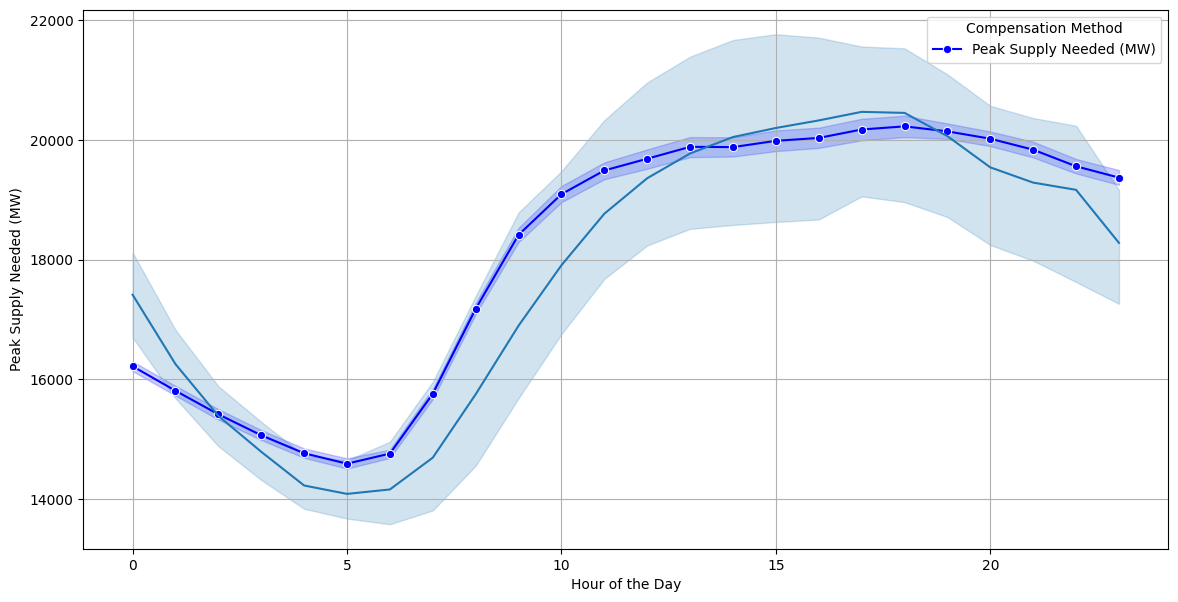

FileNotFoundError: [Errno 2] No such file or directory: 'output/LSTM.svg'

<Figure size 640x480 with 0 Axes>

In [38]:
def plot_predictions(df_predictions,name):
    plt.figure(figsize=(14, 7))

    sns.lineplot(data=df_year_predictions, x='hour_of_day', y='peak_supply_needed', marker='o', color='blue', label='Peak Supply Needed (MW)')
    
    sns.lineplot(data=df.head(100), x='hour_of_day', y='load', palette='Set1')

    # plt.title('Hourly Predictions for {}'.format(df_predictions['date'][0]))
    plt.xlabel('Hour of the Day')
    plt.ylabel('Peak Supply Needed (MW)')
    plt.legend(title='Compensation Method')
    plt.grid(True)
    plt.show()
    
    #save as svg
    plt.savefig(f'output/{name}.svg')

plot_predictions(df_year_predictions,'LSTM')

C:\Users\ariel\AppData\Local\Temp\ipykernel_7628\3804829911.py:6: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(data=df.head(100), x='hour_of_day', y='load', palette='Set1')


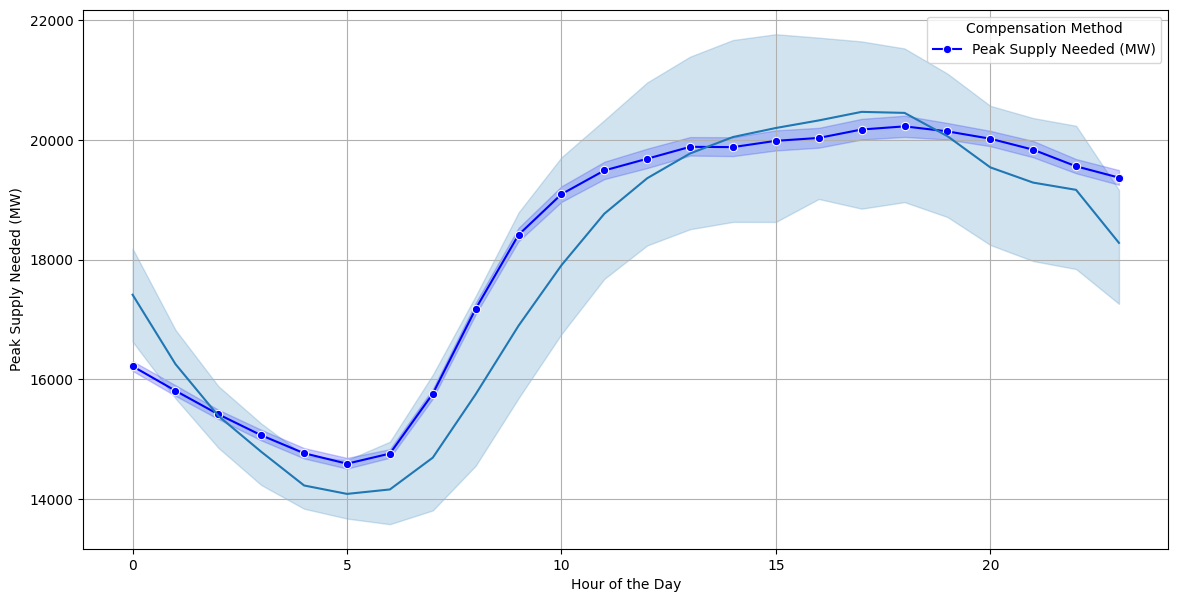

In [31]:
plot_predictions(df_year_predictions_gru)

C:\Users\ariel\AppData\Local\Temp\ipykernel_7628\3804829911.py:6: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(data=df.head(100), x='hour_of_day', y='load', palette='Set1')


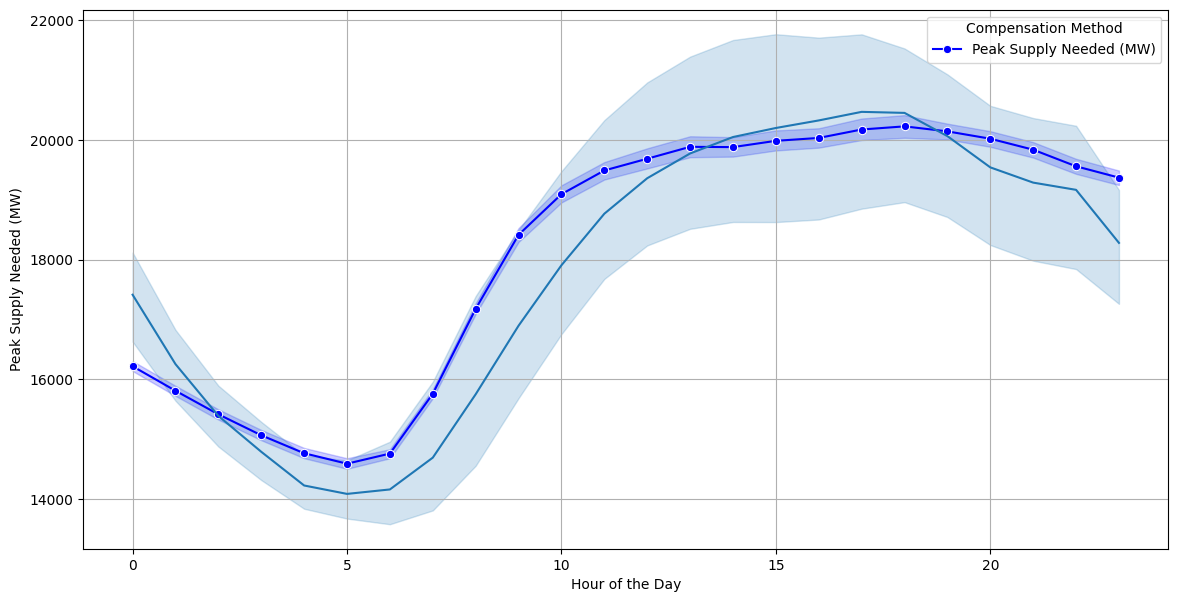

In [33]:
plot_predictions(df_year_predictions_bilstm)

In [ ]:
#save as svg



In [36]:
import pickle

with(open('models/decision_tree_classifier.pkl', 'wb')) as f:
    pickle.dump(dt, f)

# Save the LSTM model
lstm_reg.save('models/lstm_model_reg.h5')
gru_reg.save('models/gru_model_reg.h5')
bilstm_reg.save('models/bilstm_model_reg.h5')
cnn_lstm_reg.save('models/cnn_lstm_model_reg.h5')
ensemble_model.save('models/ensemble_model.h5')
xgb.save_model('models/xgb_model.json')
